<a href="https://colab.research.google.com/github/pagano81/git_test/blob/master/Coraz%C3%B3nAlexander_Ospina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a cargar los datos del Titanic

In [162]:
# Procesamiento de datos
from sklearn.model_selection import train_test_split
import pandas as pd
# Algebral lineal
import numpy as np
import sklearn_pandas as spd
import math

#Visualización
import seaborn as sbn
import plotnine as p9
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Preprocesado
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

#Algoritmos
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

Voy a dar permiso a google colab para que tenga acceso a mi cuenta de google drive

In [84]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Ahora vamos a cargar la base de datos de entrenamiento y de prueba

In [112]:
datos = pd.read_csv('corazon2.csv')
datos.info()
datos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      303 non-null    int64  
 1   Age             303 non-null    int64  
 2   Sex             303 non-null    object 
 3   Pain            303 non-null    object 
 4   TRestBPS        303 non-null    int64  
 5   Chol            303 non-null    int64  
 6   LowSugar        303 non-null    object 
 7   restECG         303 non-null    object 
 8   MaxHeartRate    303 non-null    int64  
 9   InducedAngina   303 non-null    object 
 10  OldPeak         303 non-null    float64
 11  Slope           303 non-null    object 
 12  VesselsColored  303 non-null    object 
 13  thal            303 non-null    object 
 14  HeartCondition  303 non-null    int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 35.6+ KB


,Unnamed: 0,Age,TRestBPS,Chol,MaxHeartRate,OldPeak,HeartCondition
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,151.000000,54.366337,131.623762,246.264026,149.646865,1.039604,0.455446
std,87.612784,9.082101,17.538143,51.830751,22.905161,1.161075,0.498835
min,0.000000,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,75.500000,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,151.000000,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000
75%,226.500000,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,302.000000,77.000000,200.000000,564.000000,202.000000,6.200000,1.000000


Esta última orden nos muestra la media, la desviación estandard, los cuartiles los máximos y mínimos de cada categoría. Los datos están balanceados en cuanto a los que tienen buena y mala condición cardiaca. De la misma manera se evidencian rangos muy amplios en todos las categorías.
Ahora miraremos los enunciados de la tabla.

In [113]:
datos.head()

,Unnamed: 0,Age,Sex,Pain,TRestBPS,Chol,LowSugar,restECG,MaxHeartRate,InducedAngina,OldPeak,Slope,VesselsColored,thal,HeartCondition
0,0,63,male,angina,145,233,true,hyp,150,fal,2.3,down,0.0,fix,0
1,1,67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3.0,norm,1
2,2,67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2.0,rev,1
3,3,37,male,notang,130,250,fal,norm,187,fal,3.5,down,0.0,norm,0
4,4,41,fem,abnang,130,204,fal,hyp,172,fal,1.4,up,0.0,norm,0


Acá vemos que no es necesaria la primera columna. Estas columna la podemos obviar al igual que la columna de azúcar bajo, ya que está demasiado desbalanceada y la mayoría en negativa.

In [114]:
datos=datos.drop(['Unnamed: 0','LowSugar', 'thal', 'VesselsColored'], axis=1,)
datos.head()


,Age,Sex,Pain,TRestBPS,Chol,restECG,MaxHeartRate,InducedAngina,OldPeak,Slope,HeartCondition
0,63,male,angina,145,233,hyp,150,fal,2.3,down,0
1,67,male,asympt,160,286,hyp,108,true,1.5,flat,1
2,67,male,asympt,120,229,hyp,129,true,2.6,flat,1
3,37,male,notang,130,250,norm,187,fal,3.5,down,0
4,41,fem,abnang,130,204,hyp,172,fal,1.4,up,0


**ANÁLISIS EXPLORATORIO**

Ahora evaluaremos la distribución de las edades, ya que primero tienen muchos faltantes y el rango es muy alto desde 4 meses a 80 años.

<function matplotlib.pyplot.show>

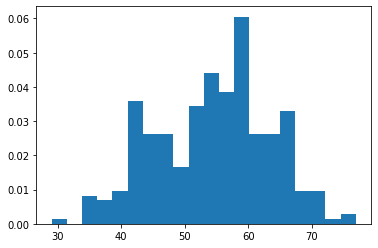

In [115]:
plt.hist(datos['Age'], bins= 20, density=True, )
plt.show

Como podemos apreciar en este histograma, la característica edad, no tiene un distribución normal, es bimodal, osea que son dos poblaciones muy diferentes, menores de 50 años y mayores de 50 años, sumado al hecho que tiene muchos valores extremos hacia la derecha y un valor extremo a la izquierda. La enfermedad coronaria en menores de 30 años es muy rara, por lo que implicaría que este paciente tiene predisponibilidad genética y no corresponde al resto de la población. Eso quiere decir inicialmente, que los valores faltantes no se pueden llenar con la media sino con la moda, y que tomando en cuenta los valores tan extremos, se hace menester escalar los valores a Z, es decir, llevarlos a una media de 0 con una desviación standar de 1

Ahora miraremos si están balanceadas las características de clases y de sexo

<function matplotlib.pyplot.show>

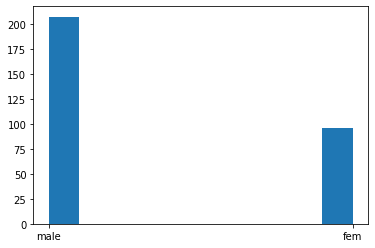

In [116]:
plt.hist(datos['Sex'] )
plt.show

Acá se evidencia, que los hombres con enfermedad cardiaca superan por el doble al de las mujeres, lo cual es esperable, ya que las mujeres adquieren la misma probabilidad de enfermedad cardiaca que los hombres después de la menopausia.
Comprobaremos esta hipótesis, graficando edad versus sexo.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


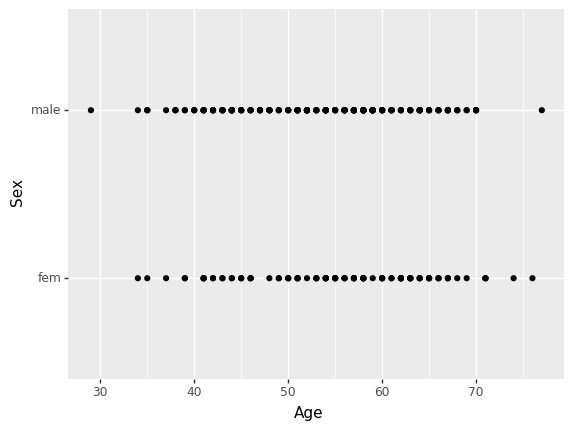

<ggplot: (8774183114973)>

In [117]:
surveys_plot = p9.ggplot(data=datos, mapping=p9.aes(x='Age', y='Sex'))
surveys_plot + p9.geom_point()

En esta gráfica evidenciamos que el grueso de la población está entre 45 y 65 años, que las mujeres aumentan su riesgo vascular después de los 40 fecha de la menopausia y que como en promedio las mujeres viven 7 a 10 años más que los hombres, los valores extremos a la derecha, corresponden tres veces más a mujeres que a hombres. Lo contrario para lo hombres, las predisposiciones genéticas que si bien se pueden presentar en cualquier sexo, predominan en los hombres.
Ahora, en esta gráfica evidenciamos que los valores extremos en una distribución no normal y bimodal tergiversarían los datos, se eliminarán los valores extremos ya que son pocos, Eliminaremos menore de 35 años y mayores de 70.

<function matplotlib.pyplot.show>

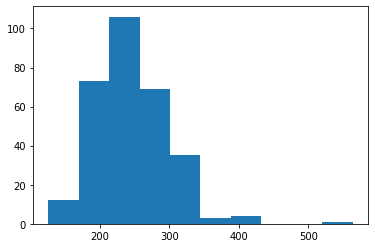

In [118]:
plt.hist(datos['Chol'] )
plt.show

En esta gráfica, encontramos que el promedio de los valores de colesterol se encuentran entre 90 y 400 con un solo valor extremo de 500, evidenciaremos la distribución por edad y sexo.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


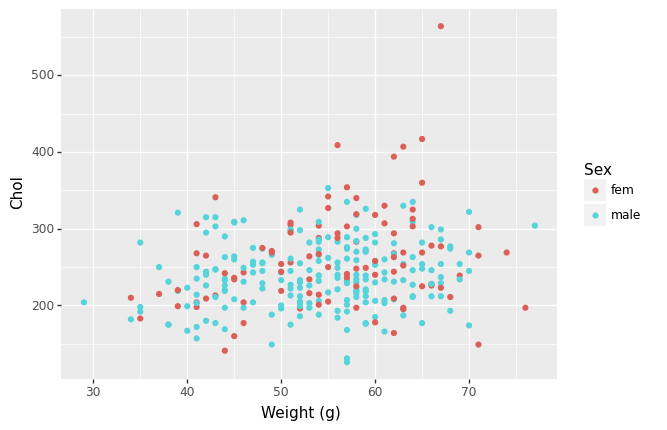

<ggplot: (8774173866349)>

In [119]:
surveys_plot = p9.ggplot(data=datos, mapping=p9.aes(x='Age', y='Chol', color= 'Sex'))
surveys_plot + p9.geom_point() + p9.xlab("Weight (g)")

Llama la atención en esta gráfica, que el colesterol tiene valores más extremos que la edad y predomininan en mujeres con valores que superan los 350mg/dl

Evaluaremos el grado de correlación de las variables numéricas.

In [121]:


# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)



,variable_1,variable_2,r,abs_r
34,HeartCondition,OldPeak,0.430696,0.430696
29,OldPeak,HeartCondition,0.430696,0.430696
23,MaxHeartRate,HeartCondition,-0.421741,0.421741
33,HeartCondition,MaxHeartRate,-0.421741,0.421741
18,MaxHeartRate,Age,-0.398522,0.398522
3,Age,MaxHeartRate,-0.398522,0.398522
22,MaxHeartRate,OldPeak,-0.344187,0.344187
27,OldPeak,MaxHeartRate,-0.344187,0.344187
6,TRestBPS,Age,0.279351,0.279351
1,Age,TRestBPS,0.279351,0.279351


Evidenciamos que tienen muy mala correlación entre sí. Evaluaremos si se puede hacer más sencillo el modelo, con los valores obtenidos de las correlaciones.

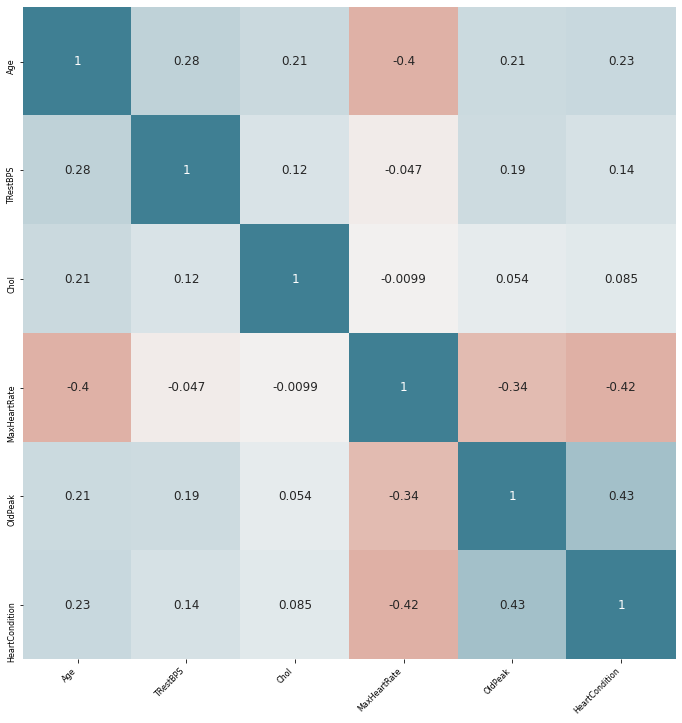

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

sbn.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sbn.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

Ahora evaluaremos las variables de tipo categórico

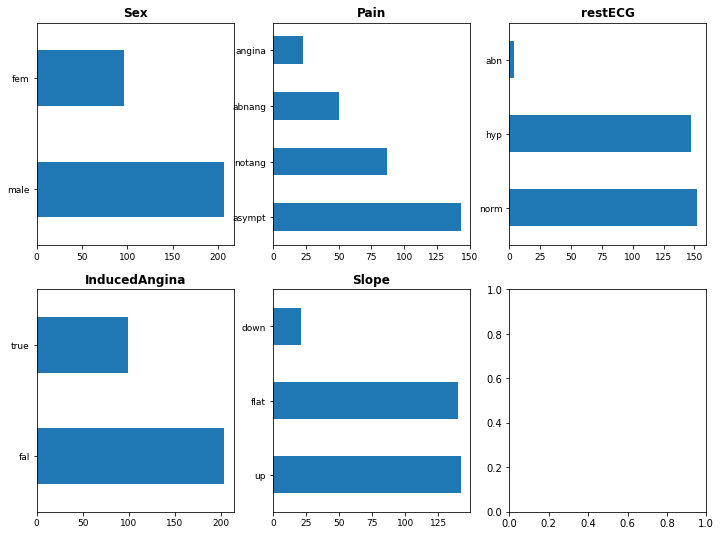

In [124]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 9))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")

Relacionaremos las relaciones entre variables cualitativas versus la condición cardiaca

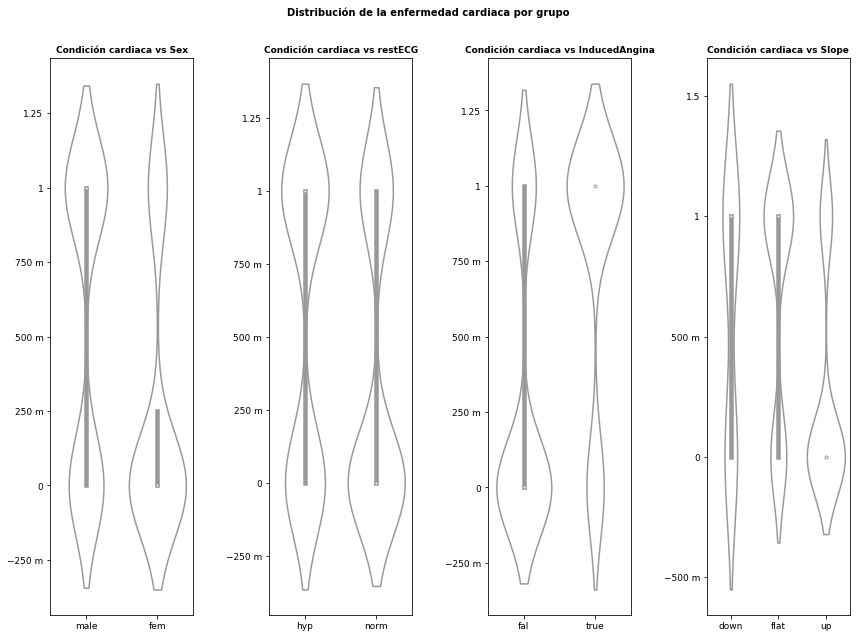

In [159]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 9))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sbn.violinplot(
        x     = colum,
        y     = 'HeartCondition',
        data  = datos,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"Condición cardiaca vs {colum}", fontsize = 9, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los ejes vacíos
#for i in [3, 4]:
 #   fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de la enfermedad cardiaca por grupo', fontsize = 10, fontweight = "bold");

In [136]:
datos=datos.drop(['Pain'], axis=1,)
datos.head()

,Age,Sex,TRestBPS,Chol,restECG,MaxHeartRate,InducedAngina,OldPeak,Slope,HeartCondition
0,63,male,145,233,hyp,150,fal,2.3,down,0
1,67,male,160,286,hyp,108,true,1.5,flat,1
2,67,male,120,229,hyp,129,true,2.6,flat,1
3,37,male,130,250,norm,187,fal,3.5,down,0
4,41,fem,130,204,hyp,172,fal,1.4,up,0


Como vemos en esta gráfica, la variable dolor no aporta nada a la condición cardiaca, ya que la mayoría de los datos nos indican que en condición cardiaca la mayoría no tenía dolor. Esta variable la podemos eliminar.

Acá vemos que a ninguna característica le hace falta ningún dato, así que no hay que imputar datos faltantes, por lo que solo nos queda escalar a Z todos los valores y convertir en 0 y 1 los valores categóricos.

**CREACIÓN DE LOS SUBCONJUNTOS DE ENTRENAMIENTO Y DE PRUEBA**

Ahora vamos a crear los subconjuntos de entrenamiento y de prueba, usando como variable objetivo 'HeartCondition', la cual debe estar presente en ambos subconjuntos. Dividiremos el 70% de entrenamiento y el 30% de prueba. Utilizaremos 'barajamiento' de datos para garantizar la máxima aleatoridad posible y para que haya reproducibilidad, añadiremos un valor semilla.

In [138]:
X_train, X_test, y_train, y_test = train_test_split(datos.drop('HeartCondition', axis = 'columns'),
                                                    datos['HeartCondition'],
                                                    train_size   = 0.7,
                                                    random_state = 1234,
                                                    shuffle      = True)

In [139]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count    212.000000
mean       0.433962
std        0.496793
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: HeartCondition, dtype: float64


In [140]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count    91.000000
mean      0.505495
std       0.502740
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: HeartCondition, dtype: float64


Acabamos de comprobar que la variable objetivo, está presente en ambos grupos.

**PREPROCESADO**
Transformaciones de las variables.

In [160]:
total = datos.isnull().sum().sort_values(ascending=False)
percent_1 = datos.isnull().sum()/datos.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(13)

,Total,%
HeartCondition,0,0.0
Slope,0,0.0
OldPeak,0,0.0
InducedAngina,0,0.0
MaxHeartRate,0,0.0
restECG,0,0.0
Chol,0,0.0
TRestBPS,0,0.0
Sex,0,0.0
Age,0,0.0


Acá vemos que a ninguna característica le hace falta ningún dato, así que no hay que imputar datos faltantes.

No se deben incluir en el modelo predictores que contengan un único valor (cero-varianza) ya que no aportan información. Tampoco es conveniente incluir predictores que tengan una varianza próxima a cero, es decir, predictores que toman solo unos pocos valores, de los cuales, algunos aparecen con muy poca frecuencia. El problema con estos últimos es que pueden convertirse en predictores con varianza cero cuando se dividen las observaciones por validación cruzada o bootstrap.


Si bien la eliminación de predictores no informativos podría considerarse un paso propio del proceso de selección de predictores, dado que consiste en un filtrado por varianza, tiene que realizarse antes de estandarizar los datos, ya que después, todos los predictores tienen varianza 1.


Recordar que las redes neuronales y los modelos aprendizajes soportados en vectores son regresiones lineales, por lo que los valores extremos o las distribuciones no normales, afectan el normal desempeño ya que los predictores que se salgan de una escala o que tengan una varianza mayor dominarńa el modelo aunque estos no tenga una buena correlación.

En nuestro caso los escalaremos a Z, esto es, variaza 1 y media de 0.

En el siguiente código escalaremos a Z las variables numéricas y binarizaremos las variables categóricas.

In [164]:
columnas_numericas= X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
columnas_categoricas = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocesador = ColumnTransformer([('scale', StandardScaler(), columnas_numericas),('onehot', OneHotEncoder(handle_unknown='ignore'),
                                                                                    columnas_categoricas)],remainder='passthrough')

Aplicaremos las transformaciones a ambos grupos.

In [172]:
X_train_prep = preprocesador.fit_transform(X_train)
X_test_prep  = preprocesador.transform(X_test)

Acá pasamos de un marco de datos con etiquetas, a un arreglo de numpy.
Ahora con las transformaciones, reconstruiremos el marco de datos con sus etiquetas.

In [173]:
encoded_cat = preprocesador.named_transformers_['onehot'].get_feature_names(columnas_categoricas)
etiquetas = np.concatenate([columnas_numericas, encoded_cat])
datos_train_prep = preprocesador.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=etiquetas)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 212 non-null    float64
 1   TRestBPS            212 non-null    float64
 2   Chol                212 non-null    float64
 3   MaxHeartRate        212 non-null    float64
 4   OldPeak             212 non-null    float64
 5   Sex_fem             212 non-null    float64
 6   Sex_male            212 non-null    float64
 7   restECG_hyp         212 non-null    float64
 8   restECG_norm        212 non-null    float64
 9   InducedAngina_fal   212 non-null    float64
 10  InducedAngina_true  212 non-null    float64
 11  Slope_down          212 non-null    float64
 12  Slope_flat          212 non-null    float64
 13  Slope_up            212 non-null    float64
dtypes: float64(14)
memory usage: 23.3 KB


**CREACIÓN DEL MODELO**

Primer modelo SGD

In [175]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train_prep, y_train)
Y_pred = sgd.predict(X_test_prep)

sgd.score(X_train_prep, y_train)

acc_sgd = round(sgd.score(X_train_prep, y_train) * 100, 2)

Segundo modelo Ramdon Forest

In [177]:
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train_prep, y_train)

Y_prediction = random_forest.predict(X_test_prep)

random_forest.score(X_train_prep, y_train)
acc_random_forest = round(random_forest.score(X_train_prep, y_train) * 100, 2)

Tercer modelo. Regresión Logística

In [178]:
logreg = LogisticRegression()
logreg.fit(X_train_prep, y_train)

Y_pred = logreg.predict(X_test_prep)

acc_log = round(logreg.score(X_train_prep, y_train) * 100, 2)

Cuarto modelo K vecinos más pŕoximos

In [179]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_prep, y_train)
Y_pred = knn.predict(X_test_prep)
acc_knn = round(knn.score(X_train_prep, y_train) * 100, 2)

Quinto modelo Gaussian Naive Bayes

In [180]:
gaussian = GaussianNB()
gaussian.fit(X_train_prep, y_train)
Y_pred = gaussian.predict(X_test_prep)
acc_gaussian = round(gaussian.score(X_train_prep, y_train) * 100, 2)

Sexto modelo Perceptrón

In [181]:
perceptron = Perceptron(max_iter=10)
perceptron.fit(X_train_prep, y_train)

Y_pred = perceptron.predict(X_test_prep)

acc_perceptron = round(perceptron.score(X_train_prep, y_train) * 100, 2)

Séptimo modelo aprendizaje con soporte en vectores

In [182]:
linear_svc = LinearSVC(max_iter=1000)
linear_svc.fit(X_train_prep, y_train)

Y_pred = linear_svc.predict(X_test_prep)

acc_linear_svc = round(linear_svc.score(X_train_prep, y_train) * 100, 2)

Octavo modelo árboles de decisiones

In [183]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_prep, y_train)
Y_pred = decision_tree.predict(X_test_prep)
acc_decision_tree = round(decision_tree.score(X_train_prep, y_train) * 100, 2)

Comparativas de exactitud entre modelos

In [186]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Regresión logística', 
              'Árboles aleatorios', 'Naive Bayes', 'Perceptrón', 
              'Descenso de Gradiente Estocástico', 
              'Árboles de decisión'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
100.00,Árboles de decisión
98.58,Árboles aleatorios
87.74,KNN
83.49,Support Vector Machines
82.08,Regresión logística
80.19,Naive Bayes
76.89,Perceptrón
58.96,Descenso de Gradiente Estocástico
